In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from preprocessing import *

In [2]:
X = pd.read_csv('Data\X_train.csv')
y = pd.read_csv('Data\y_train.csv')
X_test = pd.read_csv('Data\X_test.csv')

X.head()
#y.head()

,id,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,0.0,14168.823171,10514.380717,3316.149698,94230.695124,102.386606,92.677127,11108.748199,10866.505510,10837.622093,...,NaN,12352.094085,846.014651,105.132144,102.112809,2090.004260,2.691845,1234.374109,1000.784475,9285.751272
1,1.0,17757.037554,NaN,4101.016273,92959.527633,NaN,99.855168,10013.959449,10826.607494,10076.101597,...,NaN,16198.071494,776.084467,106.385590,103.472030,2474.051881,2.287976,NaN,1012.626705,11750.284764
2,2.0,14226.656663,11029.642499,NaN,124055.600561,100.542483,92.860892,NaN,10492.342868,NaN,...,10329.704431,13976.063780,737.040332,103.671234,109.458246,2656.083281,2.843706,888.353607,1048.810385,9553.922728
3,3.0,8766.012436,7384.202998,2147.308418,100157.719990,104.855061,101.929026,10050.049932,10499.521099,10525.030989,...,10008.251395,6212.127347,329.044233,105.084488,104.858546,1097.785204,2.732257,927.752967,1048.357330,NaN
4,4.0,13801.016418,13269.493652,3408.316953,92048.527786,103.759758,95.789235,9667.353978,10750.783106,10618.800750,...,10095.782015,13772.061493,NaN,NaN,100.369834,2693.053231,2.702908,1471.354073,1071.284484,9423.533063


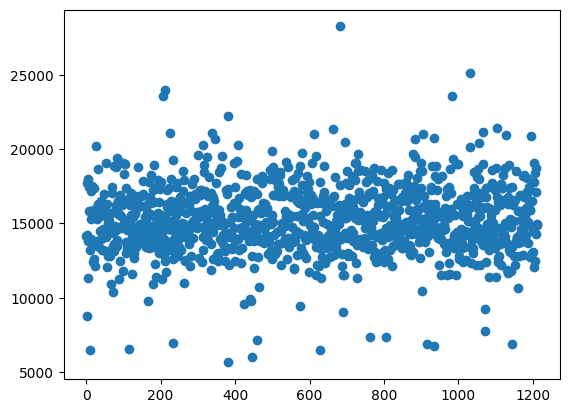

In [26]:
plt.scatter(X['id'],X['x0'])

In [27]:
print(len(X['id']))

1212


In [3]:
X.drop('id', axis=1, inplace=True)
y.drop('id', axis=1, inplace=True)
X_test.drop('id', axis=1, inplace=True)

X = X.to_numpy()
X_test.to_numpy()
y = y.to_numpy().ravel()

In [6]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV,Ridge
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [5]:
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

In [71]:
# Best Parameters Gradient Roosting Regressor : {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5}, Best Mean R² Score: 0.4594
# Best Parameters Extra Trees Regressor: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2}, Best Mean R² Score: 0.4710
# Combined Models


gboost = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
random_forest = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)
xtra_trees = ExtraTreesRegressor(n_estimators=200, max_depth=20, min_samples_split=2, random_state=42)
lasso = LassoCV(cv=10, random_state=42)


"""gboost = GradientBoostingRegressor(n_estimators=150, learning_rate=0.2, max_depth=3, random_state=42)
random_forest = RandomForestRegressor(n_estimators=150, max_depth=10, min_samples_split=10, random_state=42)
xtra_trees = ExtraTreesRegressor(n_estimators=150, max_depth=10, min_samples_split=10, random_state=42)
lasso = LassoCV(cv=7, alphas=[0.01, 0.1, 1.0, 10.0], random_state=42)"""

stacked_model = StackingRegressor(
    estimators=[
        ('gboost', gboost),
        ('random_forest', random_forest),
        ('lasso', lasso),
        ('etr', xtra_trees)
    ],
    final_estimator=Ridge(alpha=1.0),  # Meta-model
    cv=10  # Cross-validation splits for blending
)

# Data preprocessing
best_params = {'n_neighbors': 3, 'n_clusters': 3, 'contamination': 0.01}

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply imputation with the best number of neighbors
X_train_imputed, imputer = replace_NaN(X_train, best_params['n_neighbors'])
X_val_imputed = imputer.transform(X_val)

# Normalize features
X_train_normalized, scaler = normalize_features(X_train_imputed)
X_val_normalized = scaler.transform(X_val_imputed)

# Detect outliers
anomalies1 = detect_outliers_PCA_GMM(X_train_normalized, n_clusters=best_params['n_clusters'])
anomalies2 = detect_outliers_Autoencoders(X_train_normalized)
anomalies3 = detect_outliers_IsolationForest(X_train_normalized, contamination=best_params['contamination'])
anomalies = anomalies1 | anomalies2 | anomalies3



# Filter outliers from the training data
X_train_final = X_train_normalized[~anomalies]
y_train_final = y_train[~anomalies]


# Feature selection
selector = SelectKBest(f_regression, k=100)
X_train_final = selector.fit_transform(X_train_final, y_train_final)
X_val_final = selector.transform(X_val_normalized)

stacked_model.fit(X_train_final, y_train_final)

train_r2 = r2_score(y_train_final, stacked_model.predict(X_train_final))
val_r2 = r2_score(y_val, stacked_model.predict(X_val_final))

print("Training R²:", train_r2)
print("Validation R²:", val_r2)



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training R²: 0.9956630293874346
Validation R²: 0.5318417676740149


# Using a stacked model of tree-based models with XGBoost as the final estimator to increase the performance of the model

In [121]:
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV, SelectFromModel
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GroupKFold
from preprocessing import *

In [1]:
X_train, y_train = X, y

gboost = GradientBoostingRegressor(n_estimators=50, learning_rate=0.05, max_depth=5, random_state=42)
random_forest = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=2,random_state=42)
xtra_trees = ExtraTreesRegressor(n_estimators=150, max_depth=15, min_samples_split=2,random_state=42)
#gpr = GaussianProcessRegressor(alpha=1e-2, n_restarts_optimizer=10, random_state=42)

rfecv = RFECV(estimator=Lasso(alpha=0.1), step=1, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')

best_params = {'n_neighbors': 5, 'n_clusters': 5, 'contamination': 0.05}

stacked_model = make_pipeline(StackingRegressor(
    estimators=[
        ('random_forest', random_forest),
        ('etr', xtra_trees),
        ('gboost', gboost),
        ('ridge', Ridge(alpha=1.0)),
    ],
    final_estimator=XGBRegressor(
        n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42
    ),
    cv=5,  # Internal cross-validation
    n_jobs=-1,
    passthrough=True,  # Meta-model
))

X_train_imputed, imputer = replace_NaN(X_train, best_params['n_neighbors'])
#X_train_imputed, imputer = impute_median(X_train)

#anomalies1 = detect_outliers_PCA_GMM(X_train_imputed, threshold_percentile=6)
anomalies2 = detect_outliers_Autoencoders(X_train_imputed, encoding_dim=16)
anomalies3 = detect_outliers_IsolationForest(X_train_imputed, contamination=best_params['contamination'])
anomalies4 = detect_outliers_OneClassSVM(X_train_imputed, nu=0.2)
anomalies = anomalies2 | anomalies4

#print(np.where(anomalies == True))

X_train_final = X_train_imputed[~anomalies]
y_train_final = y_train[~anomalies]

X_train_final, scaler = normalize_features(X_train_final)

print(X_train_final.shape)

#selector = SelectKBest(mutual_info_regression, k=100)    
#X_train_final = selector.fit_transform(X_train_final, y_train_final)

rfecv.fit(X_train_final, y_train_final)

selected_features = rfecv.support_

X_train_final = X_train_final[:, selected_features]
score = cross_val_score(stacked_model, X_train_final, y_train_final, cv=5, n_jobs=-1)
print(score.mean(), score.std())  

NameError: name 'X' is not defined

# Model below uses ElasticNet as a final predictor in the stacked model

In [203]:
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
# Test run with Elastic-Net as final predictor in stacked model
X_train, y_train = X, y

#Best Parameters: {'stackingregressor__mlp__solver': 'adam', 'stackingregressor__mlp__learning_rate_init': 0.1, 'stackingregressor__mlp__hidden_layer_sizes': (100, 100), 'stackingregressor__mlp__alpha': 0.1, 'stackingregressor__mlp__activation': 'logistic', 'stackingregressor__gboost__max_iter': 100, 'stackingregressor__gboost__max_depth': 20, 'stackingregressor__gboost__learning_rate': 0.05, 'stackingregressor__gboost__l2_regularization': 2.0, 'stackingregressor__final_estimator__alpha': 0.001, 'stackingregressor__KRR__kernel': 'polynomial', 'stackingregressor__KRR__degree': 1, 'stackingregressor__KRR__alpha': 0.1}


#kNN = KNeighborsRegressor(n_neighbors=15, p=1, weights='distance')
gboost = HistGradientBoostingRegressor(max_iter=100, max_depth=20, learning_rate=0.05, random_state=42, l2_regularization=2.0)
KRR = KernelRidge(kernel='polynomial', degree=1, alpha=0.1)
MLP = MLPRegressor(solver='adam', learning_rate_init=0.1, hidden_layer_sizes=(100, 100), alpha=0.1, activation='logistic', random_state=42)
etr = ExtraTreesRegressor(random_state=42)
#ENet = ElasticNet(random_state=42)
#kNN = KNeighborsRegressor(n_neighbors=1, p=1, weights='distance')
#xtra_trees = ExtraTreesRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=2, random_state=42)



stacked_model = make_pipeline(StackingRegressor(
    estimators=[
        ('gboost', gboost),
        ('KRR', KRR),
        ('etr',etr)
    ],
    final_estimator=ElasticNet(random_state=42),
    n_jobs=-1,
    #passthrough=True,  # Meta-model
))


#X_train_imputed, imputer = impute_median(X_train)

anomalies1 = detect_outliers_Autoencoders(X_train, encoding_dim=16)
anomalies2 = detect_outliers_OneClassSVM(X_train, nu=0.2) # original 0.2
#anomalies2 = detect_outliers_lof(X_train_imputed, n_neighbors=20, contamination=0.01)
#anomalies3 = detect_outliers_IsolationForest(X_train_imputed, contamination=0.1)

anomalies = anomalies1 | anomalies2 



X_train_core = X_train[~anomalies]
y_train_final = y_train[~anomalies]


X_train_imputed, imputer = replace_NaN(X_train_core, n_neighbors=5)

X_train_final, scaler = normalize_features(X_train_imputed)

# Maybe try to use PCA for feature reduction
X_test_final= scaler.transform(imputer.transform(X_test))
combined_data = np.vstack((X_train_final, X_test_final))
kmeans = KMeans(n_clusters=5, random_state=42).fit(combined_data)
train_groups = kmeans.predict(X_train_final)

def log_transform(x):
    return np.log1p(x)

preprocessing_pipeline = Pipeline([
    ('selector1', VarianceThreshold(0.1)),
    ('log_transform', FunctionTransformer(log_transform)),       # Apply log transformation
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5)),
    ('selector2', SelectFromModel(Lasso(alpha=0.35))),
])

# Transform training and test data using the preprocessing pipeline
X_train_final = preprocessing_pipeline.fit_transform(X_train_final, y_train_final)
X_test_final = preprocessing_pipeline.transform(X_test_final)

# Cross-validation
gkf = GroupKFold(n_splits=5)
print(X_train_final.shape)
score = cross_val_score(stacked_model, X_train_final, y_train_final, cv=gkf, groups=train_groups, n_jobs=-1)
print(score.mean(), score.std())

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


C:\Users\smyan\anaconda3\envs\AML_projects\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(
C:\Users\smyan\AppData\Local\Temp\ipykernel_21408\826168468.py:64: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(x)
C:\Users\smyan\AppData\Local\Temp\ipykernel_21408\826168468.py:64: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(x)


(924, 75)
0.49140501326637737 0.04232018308172362


In [175]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    # HistGradientBoostingRegressor (gboost)
    'stackingregressor__gboost__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'stackingregressor__gboost__max_depth': [5, 8, 10, 15, 20],
    'stackingregressor__gboost__max_iter': [100, 200, 300, 400, 500],
    'stackingregressor__gboost__l2_regularization': [0.1, 0.5, 1.0, 2.0],

    # KernelRidge (KRR)
    'stackingregressor__KRR__alpha': [0.01, 0.1, 1, 10, 100],
    'stackingregressor__KRR__degree': [1, 2, 3, 4],
    'stackingregressor__KRR__kernel': ['polynomial', 'rbf', 'sigmoid'],

    # MLPRegressor (MLP)
    'stackingregressor__mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'stackingregressor__mlp__alpha': [0.0001, 0.001, 0.01, 0.1],
    'stackingregressor__mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'stackingregressor__mlp__activation': ['relu', 'tanh', 'logistic'],
    'stackingregressor__mlp__solver': ['adam', 'sgd', 'lbfgs'],

    # Final Estimator (Lasso)
    'stackingregressor__final_estimator__alpha': [0.001, 0.01, 0.1, 1, 10]
}

grid_search = RandomizedSearchCV(estimator=stacked_model, param_distributions=param_grid, cv=gkf.split(X_train_final, y_train_final, groups=train_groups), scoring='r2', n_jobs=-1, verbose=2, random_state=42, n_iter=500)
grid_search.fit(X_train_final, y_train_final)


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


C:\Users\smyan\anaconda3\envs\AML_projects\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
91 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\smyan\anaconda3\envs\AML_projects\lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
  File "C:\Users\smyan\anaconda3\envs\AML_projects\lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\smyan\anaconda3\envs\AML_projects\lib\site-packages\joblib\parallel.py", line 598, in <listcomp

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000027ABE059E00>,
                   estimator=Pipeline(steps=[('stackingregressor',
                                              StackingRegressor(estimators=[('gboost',
                                                                             HistGradientBoostingRegressor(random_state=42)),
                                                                            ('KRR',
                                                                             KernelRidge(degree=2,
                                                                                         kernel='polynomial')),
                                                                            ('mlp',
                                                                             MLPRegressor())],
                                                                final_estimator=Lasso(),
                                                                n_jobs=-1))]),
                   n_iter=500, n_jobs=-1,
                   param_...
                                        'stackingregressor__mlp__activation': ['relu',
                                                                               'tanh',
                                                                               'logistic'],
                                        'stackingregressor__mlp__alpha': [0.0001,
                                                                          0.001,
                                                                          0.01,
                                                                          0.1],
                                        'stackingregressor__mlp__hidden_layer_sizes': [(50,),
                                                                                       (100,),
                                                                                       (50,
                                                                                        50),
                                                                                       (100,
                                                                                        50),
                                                                                       (100,
                                                                                        100)],
                                        'stackingregressor__mlp__learning_rate_init': [0.0001,
                                                                                       0.001,
                                                                                       0.01,
                                                                                       0.1],
                                        'stackingregressor__mlp__solver': ['adam',
                                                                           'sgd',
                                                                           'lbfgs']},
                   random_state=42, scoring='r2', verbose=2)

In [176]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'stackingregressor__mlp__solver': 'adam', 'stackingregressor__mlp__learning_rate_init': 0.1, 'stackingregressor__mlp__hidden_layer_sizes': (100, 100), 'stackingregressor__mlp__alpha': 0.1, 'stackingregressor__mlp__activation': 'logistic', 'stackingregressor__gboost__max_iter': 100, 'stackingregressor__gboost__max_depth': 20, 'stackingregressor__gboost__learning_rate': 0.05, 'stackingregressor__gboost__l2_regularization': 2.0, 'stackingregressor__final_estimator__alpha': 0.001, 'stackingregressor__KRR__kernel': 'polynomial', 'stackingregressor__KRR__degree': 1, 'stackingregressor__KRR__alpha': 0.1}


## Hyperparameter tuning for the XGBoost stacked model

In [35]:
# Hyper parameter tuning for stacked model above:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'stackingregressor__random_forest__n_estimators': [50, 100, 150],
    'stackingregressor__random_forest__max_depth': [10, 15, 20],
    'stackingregressor__random_forest__min_samples_split': [2, 5, 10],

    'stackingregressor__etr__n_estimators': [50, 100, 150],
    'stackingregressor__etr__max_depth': [10, 15, 20],
    'stackingregressor__etr__min_samples_split': [2, 5, 10],

    'stackingregressor__gboost__n_estimators': [50, 100, 150],
    'stackingregressor__gboost__learning_rate': [0.05, 0.1, 0.2],
    'stackingregressor__gboost__max_depth': [3, 5, 7],

    'stackingregressor__final_estimator__n_estimators': [50, 100, 150],
    'stackingregressor__final_estimator__max_depth': [3, 5, 7],
    'stackingregressor__final_estimator__learning_rate': [0.05, 0.1, 0.2]
}

# Instantiate GridSearchCV with the stacked model and param grid
grid_search = RandomizedSearchCV(estimator=stacked_model, param_distributions=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2, random_state=42, n_iter=100)
grid_search.fit(X_train_final, y_train_final)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('stackingregressor',
                                              StackingRegressor(cv=5,
                                                                estimators=[('random_forest',
                                                                             RandomForestRegressor(max_depth=10,
                                                                                                   min_samples_split=5,
                                                                                                   random_state=42)),
                                                                            ('etr',
                                                                             ExtraTreesRegressor(max_depth=10,
                                                                                                 random_state=42)),
                                                                            ('gboost',
                                                                             GradientBoostingRegressor(random_state=42))],
                                                                final_estimator=XGBRegressor(base_score=N...
                                        'stackingregressor__gboost__learning_rate': [0.05,
                                                                                     0.1,
                                                                                     0.2],
                                        'stackingregressor__gboost__max_depth': [3,
                                                                                 5,
                                                                                 7],
                                        'stackingregressor__gboost__n_estimators': [50,
                                                                                    100,
                                                                                    150],
                                        'stackingregressor__random_forest__max_depth': [10,
                                                                                        15,
                                                                                        20],
                                        'stackingregressor__random_forest__min_samples_split': [2,
                                                                                                5,
                                                                                                10],
                                        'stackingregressor__random_forest__n_estimators': [50,
                                                                                           100,
                                                                                           150]},
                   random_state=42, scoring='r2', verbose=2)

In [36]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'stackingregressor__random_forest__n_estimators': 100, 'stackingregressor__random_forest__min_samples_split': 2, 'stackingregressor__random_forest__max_depth': 15, 'stackingregressor__gboost__n_estimators': 50, 'stackingregressor__gboost__max_depth': 5, 'stackingregressor__gboost__learning_rate': 0.05, 'stackingregressor__final_estimator__n_estimators': 50, 'stackingregressor__final_estimator__max_depth': 3, 'stackingregressor__final_estimator__learning_rate': 0.1, 'stackingregressor__etr__n_estimators': 150, 'stackingregressor__etr__min_samples_split': 2, 'stackingregressor__etr__max_depth': 15}


## Hyper parameter tuning for the stacked model with Lasso as the final estimator

In [71]:
from sklearn.model_selection import RandomizedSearchCV
param_distributions = {
    # HistGradientBoosting parameters
    'stackingregressor__gboost__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'stackingregressor__gboost__max_depth': [5, 10, 15, 20],
    'stackingregressor__gboost__max_iter': [100, 200, 300],
    'stackingregressor__gboost__l2_regularization': [0, 0.1, 0.5, 1.0],  # Control overfitting

    # ExtraTrees parameters
    'stackingregressor__etr__n_estimators': [50, 100, 150, 200],
    'stackingregressor__etr__max_depth': [10, 15, 20, 25],
    'stackingregressor__etr__min_samples_split': [2, 5, 10],
    'stackingregressor__etr__min_samples_leaf': [1, 2, 5],  # Controls overfitting

    # kNN parameters
    'stackingregressor__kNN__n_neighbors': [1, 3, 5, 10, 15],
    'stackingregressor__kNN__p': [1, 2],  # Manhattan (p=1) or Euclidean (p=2) distance
    'stackingregressor__kNN__weights': ['uniform', 'distance'],  # Use either uniform or distance-based weighting

    # ElasticNet final estimator parameters
    'stackingregressor__final_estimator__alpha': np.logspace(-4, 1, 6),  # Range for regularization strength
    'stackingregressor__final_estimator__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Balance between L1 and L2 regularization
}

grid_search = RandomizedSearchCV(estimator=stacked_model, param_distributions=param_distributions, cv=gkf.split(X_train_final, y_train_final, groups=train_groups), scoring='r2', n_jobs=-1, verbose=2, random_state=42, n_iter=200)

grid_search.fit(X_train_final, y_train_final)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000027A7FA43A00>,
                   estimator=Pipeline(steps=[('stackingregressor',
                                              StackingRegressor(cv=10,
                                                                estimators=[('etr',
                                                                             ExtraTreesRegressor(max_depth=25,
                                                                                                 min_samples_leaf=5,
                                                                                                 min_samples_split=10,
                                                                                                 n_estimators=150,
                                                                                                 random_state=42)),
                                                                            ('gboost',
                                                                             HistGradientBoostingRegressor(l2_regularization=1.0,
                                                                                                           learning_rate=...
                                        'stackingregressor__gboost__learning_rate': [0.01,
                                                                                     0.05,
                                                                                     0.1,
                                                                                     0.2,
                                                                                     0.3],
                                        'stackingregressor__gboost__max_depth': [5,
                                                                                 10,
                                                                                 15,
                                                                                 20],
                                        'stackingregressor__gboost__max_iter': [100,
                                                                                200,
                                                                                300],
                                        'stackingregressor__kNN__n_neighbors': [1,
                                                                                3,
                                                                                5,
                                                                                10,
                                                                                15],
                                        'stackingregressor__kNN__p': [1, 2],
                                        'stackingregressor__kNN__weights': ['uniform',
                                                                            'distance']},
                   random_state=42, scoring='r2', verbose=2)

In [72]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'stackingregressor__kNN__weights': 'distance', 'stackingregressor__kNN__p': 1, 'stackingregressor__kNN__n_neighbors': 15, 'stackingregressor__gboost__max_iter': 200, 'stackingregressor__gboost__max_depth': 15, 'stackingregressor__gboost__learning_rate': 0.01, 'stackingregressor__gboost__l2_regularization': 0.1, 'stackingregressor__final_estimator__l1_ratio': 0.1, 'stackingregressor__final_estimator__alpha': 0.1, 'stackingregressor__etr__n_estimators': 200, 'stackingregressor__etr__min_samples_split': 10, 'stackingregressor__etr__min_samples_leaf': 2, 'stackingregressor__etr__max_depth': 10}


In [105]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
X_train, y_train = X, y

#rfecv = RFECV(estimator=Lasso(alpha=0.3), step=1, cv=10, n_jobs=-1,scoring='r2')

#Best Parameters: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 0.5, 'colsample_bytree': 0.4, 'alpha': 0.5}


model = HistGradientBoostingRegressor()
X_train_imputed, imputer = replace_NaN(X_train, n_neighbors=5)
#X_train_imputed, imputer = impute_median(X_train)

anomalies1 = detect_outliers_Autoencoders(X_train_imputed, encoding_dim=16)
anomalies2 = detect_outliers_OneClassSVM(X_train_imputed, nu=0.2) # original 0.2
#anomalies3 = detect_outliers_IsolationForest(X_train_imputed, contamination=0.1)

anomalies = anomalies1 | anomalies2


#print(np.where(anomalies == True))

X_train_final = X_train_imputed[~anomalies]
y_train_final = y_train[~anomalies]

X_train_final, scaler = normalize_features(X_train_final)

#selector = SelectKBest(mutual_info_regression, k=100)    
#X_train_final = selector.fit_transform(X_train_final, y_train_final)

# Maybe try to use PCA for feature reduction

X_test_final= scaler.transform(imputer.transform(X_test))


combined_data = np.vstack((X_train_final, X_test_final))
kmeans = KMeans(n_clusters=5, random_state=42).fit(combined_data)
train_groups = kmeans.predict(X_train_final)

gkf = GroupKFold(n_splits=5)



#rfecv = RFECV(estimator=Lasso(alpha=0.1), step=2, cv=gkf.split(X_train_final, y_train_final, groups=train_groups), n_jobs=-1,scoring='r2')

#rfecv.fit(X_train_final, y_train_final)

#selected_features = rfecv.support_

#X_train_final = X_train_final[:, selected_features]
#X_test_final = X_test_final[:, selected_features]

selector = SelectKBest(mutual_info_regression, k=80)
X_train_final = selector.fit_transform(X_train_final, y_train_final)
X_test_final = selector.transform(X_test_final)

print(X_train_final.shape)
score = cross_val_score(model, X_train_final, y_train_final, cv=gkf, groups=train_groups, n_jobs=-1)
print(score.mean(), score.std())

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step


C:\Users\smyan\anaconda3\envs\AML_projects\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(


(921, 80)
0.305452328078922 0.0923187621848253


In [80]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.4, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
    'alpha': [0, 0.1, 0.3, 0.5, 1.0],
    'lambda': [1.0, 0.5, 0.3, 0.1]
}

grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, cv=gkf, scoring='r2', n_jobs=-1, verbose=2, random_state=42, n_iter=200)

grid_search.fit(X_train_final, y_train_final, groups=train_groups)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\smyan\anaconda3\envs\AML_projects\lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "_lambda" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=GroupKFold(n_splits=5),
                   estimator=XGBRegressor(_lambda=1, alpha=0.1, base_score=None,
                                          booster=None, callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          int...
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, ...),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'alpha': [0, 0.1, 0.3, 0.5, 1.0],
                                        'colsample_bytree': [0.4, 0.6, 0.8,
                                                             1.0],
                                        'lambda': [1.0, 0.5, 0.3, 0.1],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 300],
                                        'subsample': [0.4, 0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=2)

In [81]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 0.5, 'colsample_bytree': 0.4, 'alpha': 0.5}


In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_PCA = pca.fit_transform(X_train_final)
X_train_imputed_PCA = pca.fit_transform(X_train_imputed)
%matplotlib inline

plt.plot(X_train_PCA[:,0],X_train_PCA[:,1],'rx')
plt.plot(X_train_imputed_PCA[:,0],X_train_imputed_PCA[:,1],'bo')
plt.legend(['After anomaly removal','Before anomaly removal'])
plt.show()

NameError: name 'X_train_final' is not defined

In [183]:
# Submission 2
model = stacked_model.fit(X_train_final, y_train_final)

X_test_normalized = scaler.transform(imputer.transform(X_test))

X_test_final = selector2.transform(selector1.transform(X_test_normalized))

y_pred = model.predict(X_test_final)

table = pd.DataFrame({'id': np.arange(len(y_pred)), 'y': y_pred.flatten()})

table.to_csv('Data\y_test_pred.csv', index=False)


C:\Users\smyan\anaconda3\envs\AML_projects\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(
